In [154]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [155]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [156]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from datetime import timedelta, datetime

In [157]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [158]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/qf/1g7nyqn1365475byk1zh84fw0000gn/T/ipykernel_76682/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [159]:
# View all of the classes that automap found
for name in Base.classes.keys():
    print(name)

station
measurement


In [160]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [161]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [162]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

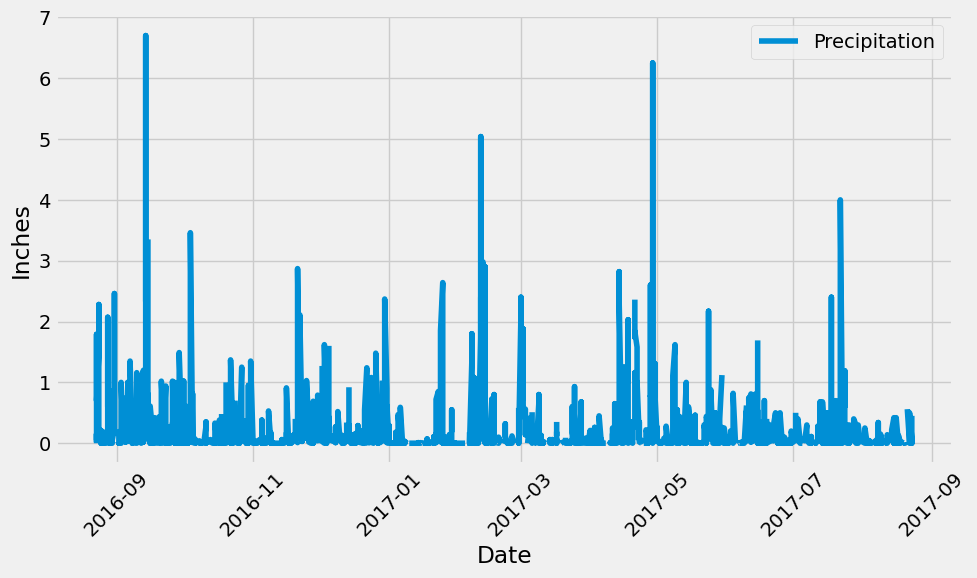

In [163]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set.
last_date = pd.to_datetime(most_recent_date)
one_year_ago = last_date - pd.DateOffset(years=1)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["Precipitation"], label="Precipitation") 
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=45)  
plt.legend()
plt.tight_layout()
plt.show()

In [164]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = pd.DataFrame(df['Precipitation'].describe())
summary

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [165]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.id)).all()

[(9,)]

In [166]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = [measurement.station,
                  func.count(measurement.station).label('station_count')]

active_station = session.query(*station_count).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [171]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
cal = [measurement.station,
       func.min(measurement.tobs).label("min_temp"),
       func.max(measurement.tobs).label("max_temp"),
       func.avg(measurement.tobs).label("avg temp")]

temp_cal = session.query(*cal).\
    filter(measurement.station == "USC00519281").\
    group_by(measurement.station).all()

print(temp_cal)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


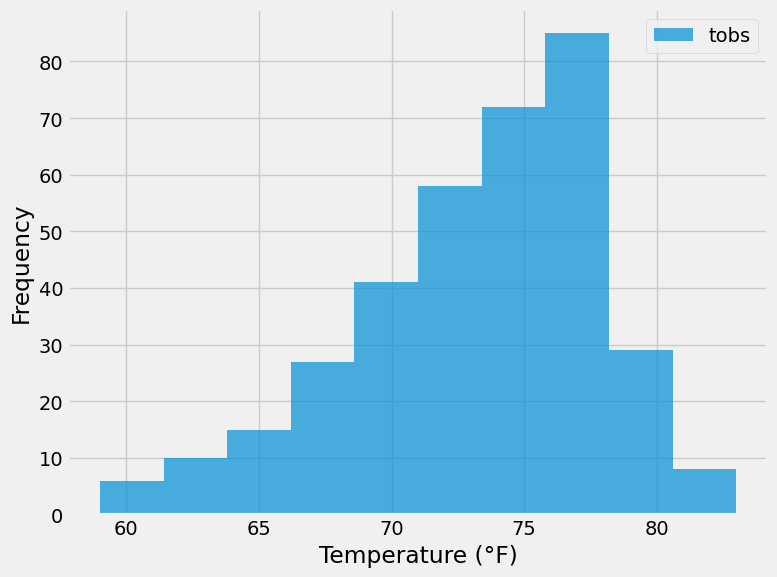

In [170]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(
    measurement.station,
    func.count(measurement.id).label('station_count')).\
    group_by(measurement.station).\
    order_by(desc('station_count')).first()[0]
    
last_date = session.query(func.max(measurement.date)).scalar()

last_date = datetime.strptime(last_date, '%Y-%m-%d')

one_year_ago = last_date - dt.timedelta(days=365)

temp_data = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= one_year_ago).all()

temp = [temp[0] for temp in temp_data]
plt.figure(figsize=(8, 6))
plt.hist(temp, alpha=0.7, label="tobs")
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Close Session

In [169]:
# Close Session
session.close()